In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from scipy.optimize import curve_fit
import h5py
from pathlib import Path    
import seaborn as sns
from collections.abc import Iterable

In [2]:
datapath = Path.cwd() / "results"

In [3]:
def rearrange_data(arr): #
    res = np.swapaxes(arr,-1,0)
    res = np.swapaxes(res,-2,1)
    return res

def disorder_mean(A, n_samples = None):
    if n_samples is None:
        return np.mean(A,2)
    else:
        return np.mean(A[:,:,0:n_samples],2)

def disorder_std(A, n_samples = None):
    if n_samples is None:
        return np.std(A,2)
    else:
        return np.std(A[:,:,0:n_samples],2)

In [4]:
def modified_disorder_mean(arr,distance_matrix):
    N = arr.shape[1]
    SHOTS = arr.shape[2]
    n_bins = int(np.max(distance_matrix))+1 #Bins [0,1),[1,2),...
    new_arr = np.zeros((arr.shape[0],n_bins))
    counts = np.zeros(n_bins)
    for shot in range(0,SHOTS):
        for j in range(0,N):
            j_eff= int(distance_matrix[0,j,shot])
            new_arr[:,j_eff] += arr[:,j,shot]
            counts[j_eff] += 1
    for bin in range(0,n_bins):
        if counts[bin] != 0:
            new_arr[:,bin] = new_arr[:,bin]/counts[bin]
    return new_arr

def count_bins(distance_matrix):
    N = distance_matrix.shape[0]
    SHOTS = distance_matrix.shape[2]
    n_bins = int(np.max(distance_matrix))+1 #Bins [0,1),[1,2),...
    counts = np.zeros(n_bins)
    for shot in range(0,SHOTS):
        for j in range(0,N):
            j_eff= int(distance_matrix[0,j,shot])
            counts[j_eff] += 1
    return counts

In [5]:
jobids = []
params = []
data = []
positiondesc = []
positions = []
distance_matrices = []
N = 16
folders = [datapath/"noisy_chain_pbc_1,9",datapath/"noisy_chain_pbc_1,6",datapath/"noisy_chain_pbc_1,4",datapath/"noisy_chain_pbc_1,3",datapath/"noisy_chain_pbc_1,0",datapath/"noisy_chain_pbc_0,8",datapath/"box_pbx_0,8",datapath/"box_pbx_0,5",datapath/"box_pbx_0,1"]
files = ["52182{}_N16_rp.jld2".format(i) for i in range(44,53)]
for (i,file) in enumerate(files):
    with h5py.File(folders[i]/file,"r") as f:
        jobids.append(f["jobid"][()].decode("UTF-8"))
        data.append(2-2*rearrange_data(f["data"][()]))
        params.append(f["params"][()])
        positiondesc.append(f["posistiondata"][()][0]) #Fix spelling in future runs!
        positions.append(np.swapaxes(f[f["posistiondata"][()][1]],0,1))
        distance_matrices.append(np.swapaxes(f[f["posistiondata"][()][2]],0,2))
T = np.arange(0,5.1,0.1)
xcenter = 1
SHOTS = 100

In [6]:
data[0].shape

(51, 16, 100)

In [7]:
#res = list(map(lambda arr: symmetrize(disorder_mean(arr)),data))
#res_err = list(map(lambda arr: symmetrize(disorder_std(arr)),data))
res = list(map(lambda arr: disorder_mean(arr),data))
res_err = list(map(lambda arr: disorder_std(arr),data))

In [8]:
res_m = list(map(lambda arr,distance_matrix: modified_disorder_mean(arr,distance_matrix), data, distance_matrices))
counts = list(map(lambda distance_matrix: count_bins(distance_matrix),distance_matrices))

In [10]:
res_m[1].shape

(51, 10)

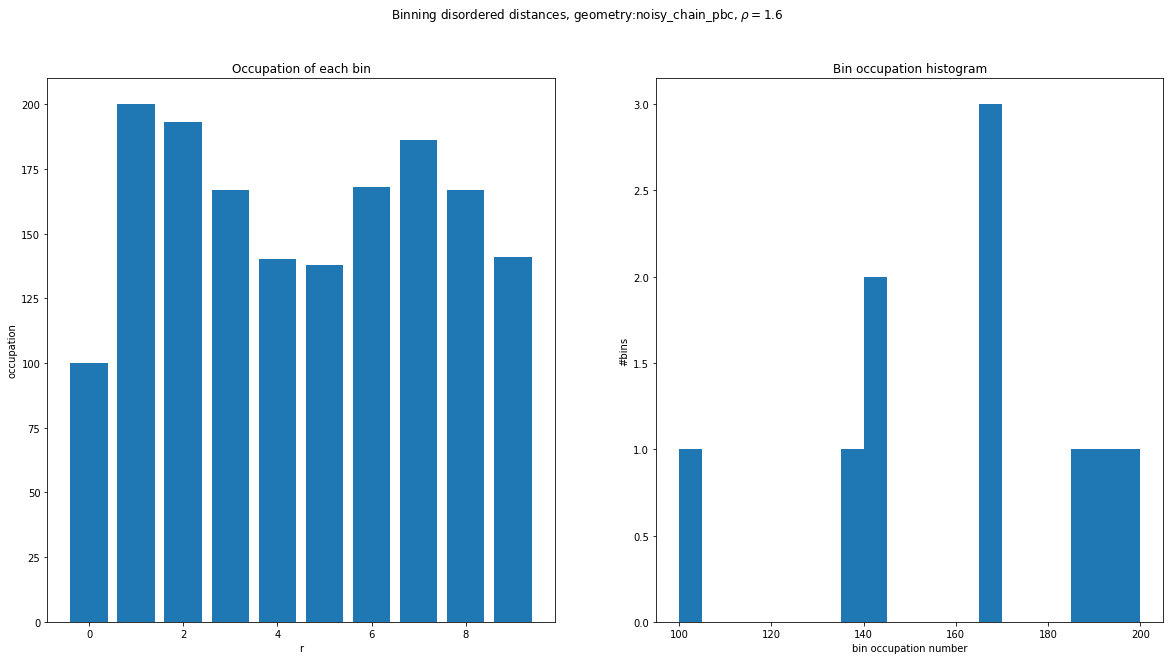

In [14]:
ds=1
bins = [i for i in range(0,len(counts[ds]))]
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[1].hist(counts[ds],20)
axs[1].set_title("Bin occupation histogram")
axs[1].set_xlabel("bin occupation number")
axs[1].set_ylabel("#bins")

axs[0].bar(bins,counts[ds])
axs[0].set_title("Occupation of each bin")
axs[0].set_xlabel("r")
axs[0].set_ylabel("occupation")
plt.suptitle(r"Binning disordered distances, geometry:{}, $\rho=${}".format(positiondesc[ds][0].decode("UTF-8"),positiondesc[ds][-1]))
plt.show()


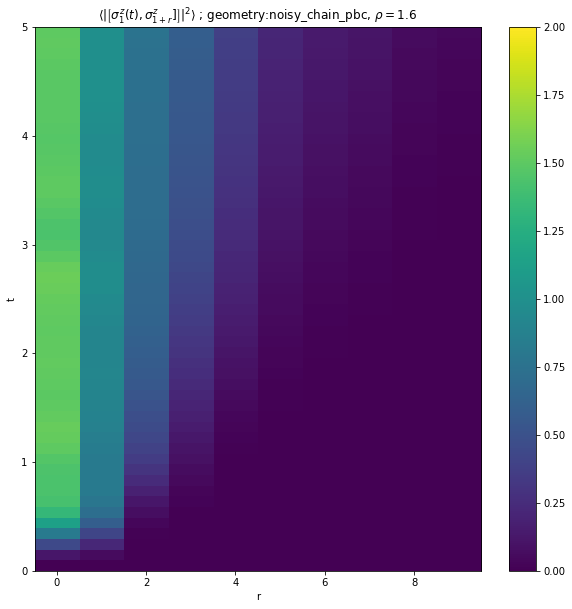

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(res_m[ds],cmap="viridis",origin="lower",aspect="auto",extent=[-0.5,len(bins)-0.5,0,T[-1]])
#for (i,th) in enumerate(thresholds):
#    plt.plot(np.arange(0,N,1)+0.5,model(xvals,*fit_params[i]),label="th = {:.2f}".format(th),color="black",ls="--")
#    plt.scatter(np.arange(0,N,1)+0.5,tvals[i], marker= "d")
plt.clim(0,2)
plt.colorbar()
plt.xlabel("r")
plt.ylabel("t")
#plt.legend()
plt.title(r"$\langle\left|\left[\sigma_1^z(t),\sigma_{1+r}^z]\right]\right|^2\rangle$"+r" ; geometry:{}, $\rho=${}".format(positiondesc[ds][0].decode("UTF-8"),positiondesc[ds][-1]))
plt.show()

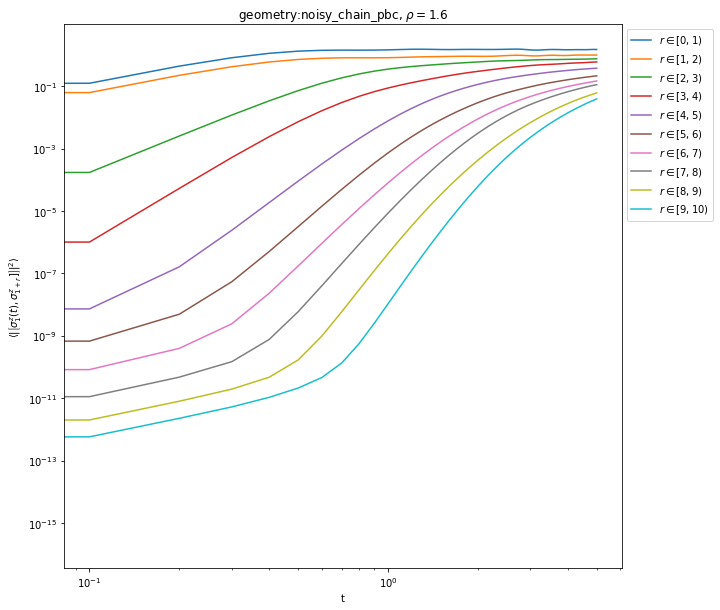

In [331]:
plt.figure(figsize=(10,10))
for j in range(0,len(bins)):
    plt.loglog(T,res_m[ds][:,j],label=r"$r\in[${}$,${}$)$".format(j,j+1))
plt.legend()
plt.title(r"geometry:{}, $\rho=${}".format(positiondesc[ds][0].decode("UTF-8"),positiondesc[ds][-1]))
plt.xlabel("t")
plt.ylabel(r"$\langle\left|\left[\sigma_1^z(t),\sigma_{1+r}^z]\right]\right|^2\rangle$")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

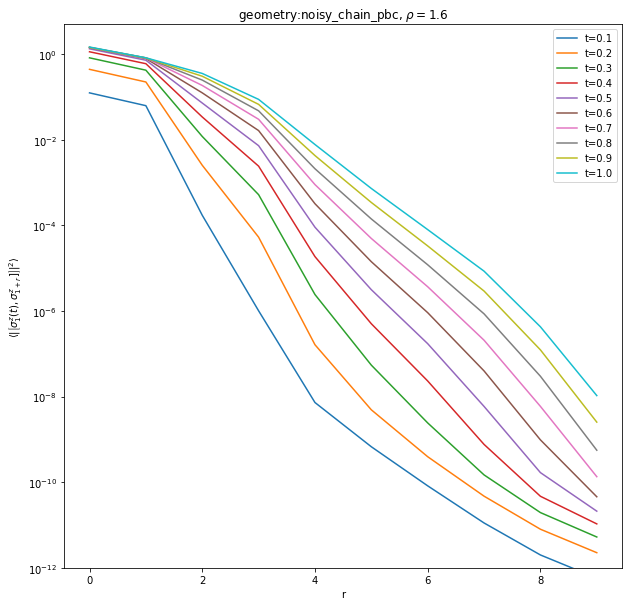

In [336]:
fig = plt.figure(figsize=(10,10))
for t in range(1,11,1):
    plt.semilogy(range(0,len(bins)),res_m[ds][t,:],label="t={:.1f}".format(t*0.1))
plt.legend(loc="lower right")
plt.xlabel("r")
plt.ylabel(r"$\langle\left|\left[\sigma_1^z(t),\sigma_{1+r}^z]\right]\right|^2\rangle$")
plt.ylim(1e-12,5)
plt.legend(bbox_to_anchor=(1, 1))
plt.title(r"geometry:{}, $\rho=${}".format(positiondesc[ds][0].decode("UTF-8"),positiondesc[ds][-1]))
plt.show()